# Topics discussed in knesset committees.
Based on transcripts of the knesset committees.<br/>
The work was done in the 'public knowledge workshop' hackathon and won 3rd place prize.

# Analyze the most talked topics in the knesset committees

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
topics_columns_names = ['Diplomacy_score', 'Ecologics_score', 'Economics_score',
                        'Education_score', 'Health_score', 'Security_score']
clean_topic_column_names = ['Diplomacy', 'Ecologics', 'Economics',
                         'Education', 'Health', 'Security']

In [3]:
# Normalize the topics' scores
def normalize_scores(scores):
    max_i = (0, -1)
    second_i = (0, -1)
    third_i = (0, -1)
    for i in range(len(scores)):
        if scores[i] != 0:
            if scores[i] > max_i[0]:
                third_i = second_i
                second_i = max_i
                max_i = (scores[i], i)
            elif scores[i] > second_i[0]:
                third_i = second_i
                second_i = (scores[i], i)
            elif scores[i] > third_i[0]:
                third_i = (scores[i], i)
        
    scores = [0] * len(scores)
    if max_i[1] != -1:
        scores[max_i[1]] = 3
    if second_i[1] != -1:
        scores[second_i[1]] = 2
    if  third_i[1] != -1:
        scores[third_i[1]] = 1
    return scores

def get_knesset_topics(knesset_num):
    # Get knesset collected data
    df_knesset = pd.read_csv("Extracted_data/meetings_topics_knesset_" + str(knesset_num) + ".csv")
    smaller_df = df_knesset[['KnessetNum', 'Year', 'Month',
                              'Diplomacy_score', 'Ecologics_score', 'Economics_score', 'Education_score',
                              'Health_score', 'Security_score']]
    
    # Normalize scores
    topics = smaller_df.apply(lambda row: normalize_scores(row[3:]), axis=1)
    topics_df = pd.DataFrame(topics)
    smaller_df[topics_columns_names] = pd.DataFrame(topics_df[0].values.tolist(), index= topics_df.index)
    smaller_df['Year.Month'] = smaller_df['Year'] + (smaller_df['Month'] -1)/12.0
    return smaller_df

# Create Graphs

## Time based graph - plot the common talked topics by month

In [4]:
def draw_knesset_topics_over_time(knesset_num):
    df = get_knesset_topics(knesset_num)
    
    # Aggredate per month and year
    by_month = df.groupby(['Year.Month']).mean()
    plt.style.use('default')

    # Plot topics graph
    by_month.plot(y=topics_columns_names,
                  title="Knesset " + str(knesset_num) + " - Most popular topics over time",
                  label = clean_topic_column_names,
                  figsize=(8,4))

## Summary graph -plot the most talked topics in a knesset overall

In [5]:
def draw_knesset_topics(knesset_num):
    df = get_knesset_topics(knesset_num)
    
    # Aggredate per month and year
    
    df_mean = df[topics_columns_names].mean()
    sns.set_palette(sns.color_palette("Dark2"))
    plt.style.use('seaborn-darkgrid')

    # Plot topics graph    
    df_mean.plot(y=topics_columns_names, 
                  title="Knesset " + str(knesset_num) + " - Most popular topics",
                  kind='barh', figsize=(8,4))

## Explaining the results - the lexicon words that appears the most in the knesset
Using this we filtered the words 'כספים' and 'אוצר' from the Economics lexicon since they represent budgets more then economy discussions.

In [6]:
import csv
from wordcloud import WordCloud

def get_and_flip_freq_dictionary_for_knesset(knesset_num):
    freq_dictionary = dict()
    with open("Extracted_data/words_freq_knesset_" + str(knesset_num) + ".csv", 'r', encoding="utf-8") as csvFile:
        reader = csv.reader(csvFile)
        first = True
        for row in reader:
            if first:
                first = False
                continue
            # we flip the word since it's in hebrew and not supported
            flipped_word = ''.join(reversed(row[1]))
            freq_dictionary[flipped_word] = int(row[2])
    return freq_dictionary

def draw_lexicon_word_cloud_per_knesset(knesset_num):
    plt.style.use('default')

    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10,
                font_path='C:/Windows/Fonts/Gisha.ttf')
    
    freq_dictionary = get_and_flip_freq_dictionary_for_knesset(knesset_num)
    wordcloud.generate_from_frequencies(frequencies=freq_dictionary, )
    plt.figure(figsize = (4, 4), facecolor = 'None')
    plt.imshow(wordcloud)

## Show correlation between discussed topics
We mainly want to know which topics are being neglected when other topics are getting special attention.

,Diplomacy_score,Ecologics_score,Economics_score,Education_score,Health_score,Security_score
Diplomacy_score,1.000000,-0.056897,-0.153866,-0.082536,-0.087134,-0.024889
Ecologics_score,-0.056897,1.000000,-0.041243,-0.101785,-0.064198,-0.078708
Economics_score,-0.153866,-0.041243,1.000000,-0.131208,-0.234036,-0.252315
Education_score,-0.082536,-0.101785,-0.131208,1.000000,-0.133712,-0.164300
Health_score,-0.087134,-0.064198,-0.234036,-0.133712,1.000000,-0.150103
Security_score,-0.024889,-0.078708,-0.252315,-0.164300,-0.150103,1.000000


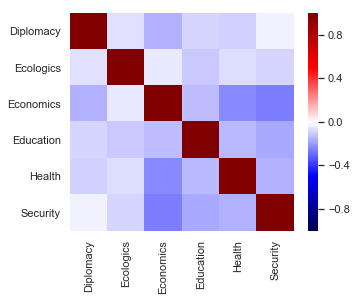

In [7]:
import seaborn as sns
def get_correlation_between_topics(knesset_nums_list):
    dfs = [get_knesset_topics(knesset_num) for knesset_num in knesset_nums_list]
    total_df = pd.concat(dfs)
    
    topics_df = total_df[topics_columns_names]

    corr_df = topics_df.corr()
    sns.set(rc={'figure.figsize':(5,4)})
    sns.heatmap(corr_df, 
            vmin=-1, vmax=1,
            xticklabels=clean_topic_column_names,
            yticklabels=clean_topic_column_names,
            cmap='seismic')
    return corr_df

get_correlation_between_topics([17,18,20])

# Graphs!

## Knesset 17 : 2006-2009

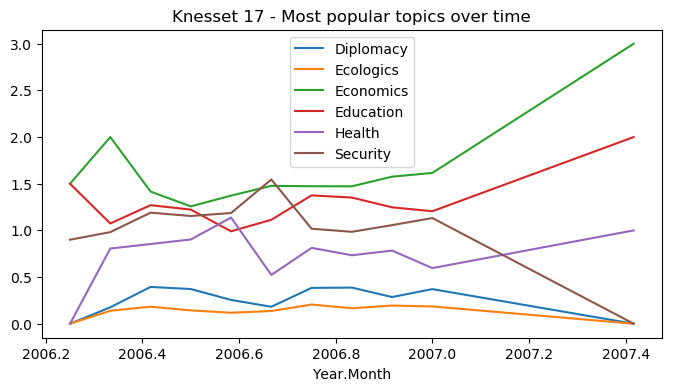

In [8]:
draw_knesset_topics_over_time(17)

### We can see two interesting things in this graph:
1. **Financial crisis of 2007-2008**: We can see that from 2007 forward the economics topics got the highest interest in that Knesset.
2. **Operation Summer Rains and the kidnapping of Gilad Shalit** - June 25, 2006 - caused a sudden jump in security.

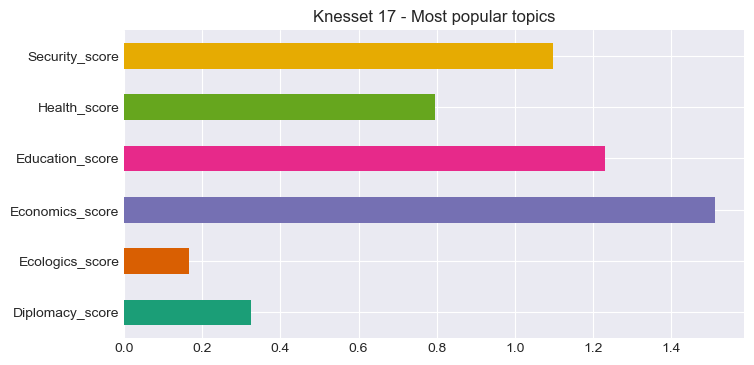

In [9]:
draw_knesset_topics(17)

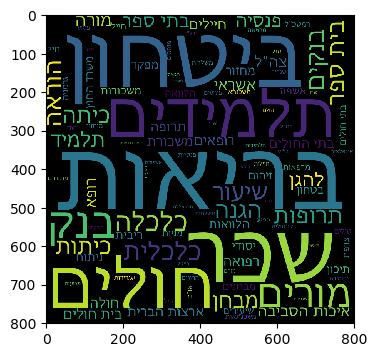

In [10]:
draw_lexicon_word_cloud_per_knesset(17)

## Knesset 18 : 2009-2013

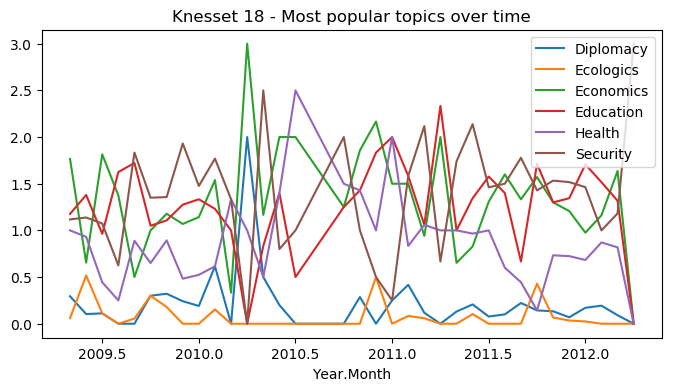

In [11]:
draw_knesset_topics_over_time(18)

We were able to find:
- **The tent protest (מחאת האוהלים)** in the summer of 2011
- **The Arab spring (winter of 2010)** - which caused a gain of interest in the diplomacy, security and the economy topics.
- **European debt crisis** which made the economics interest spike. (Especially after 2008) 
- **Doctors collective wages agreement** which came just after considering the European debt crisis

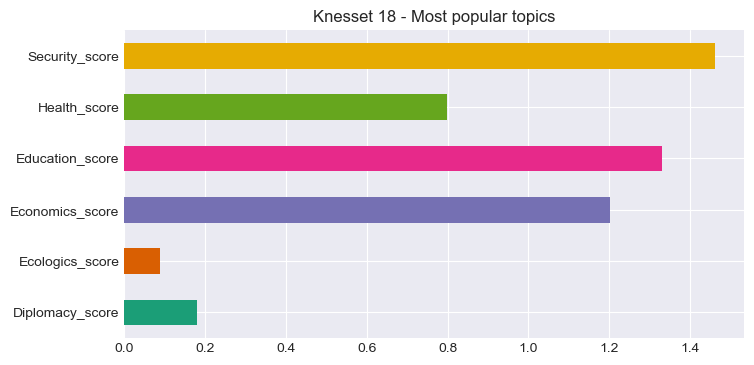

In [12]:
draw_knesset_topics(18)

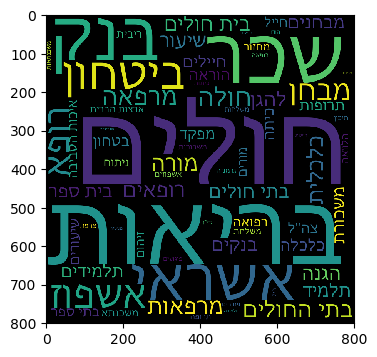

In [13]:
draw_lexicon_word_cloud_per_knesset(18)

## Knesset 20 : 2015-2019
The data from the 19 knesset was missing from the public data workshop's dataset.

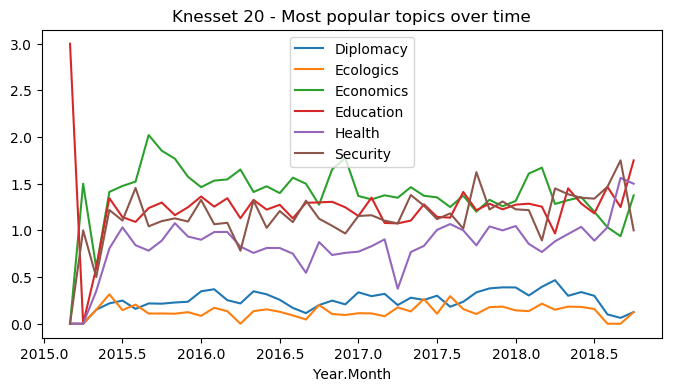

In [14]:
draw_knesset_topics_over_time(20)

This graph is basically showing inertion so it's interesting to see what is that 'normal' subject distribution.

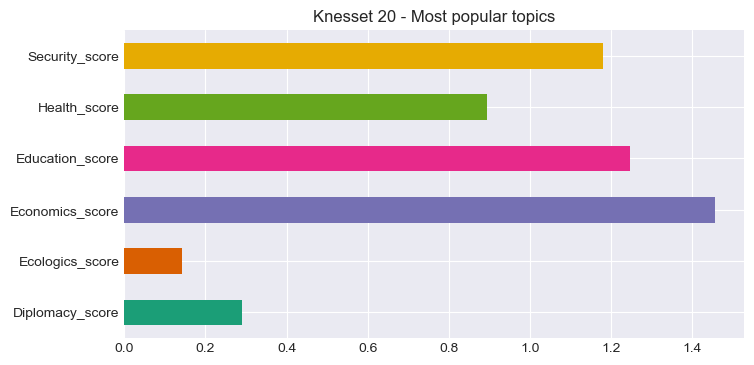

In [15]:
draw_knesset_topics(20)

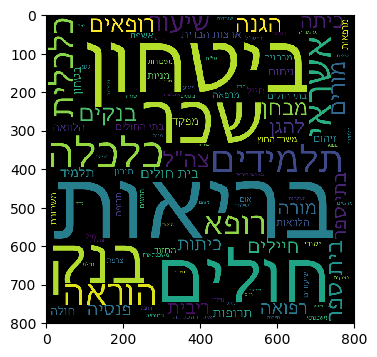

In [16]:
draw_lexicon_word_cloud_per_knesset(20)

## Correlation between topics

,Diplomacy_score,Ecologics_score,Economics_score,Education_score,Health_score,Security_score
Diplomacy_score,1.000000,-0.056897,-0.153866,-0.082536,-0.087134,-0.024889
Ecologics_score,-0.056897,1.000000,-0.041243,-0.101785,-0.064198,-0.078708
Economics_score,-0.153866,-0.041243,1.000000,-0.131208,-0.234036,-0.252315
Education_score,-0.082536,-0.101785,-0.131208,1.000000,-0.133712,-0.164300
Health_score,-0.087134,-0.064198,-0.234036,-0.133712,1.000000,-0.150103
Security_score,-0.024889,-0.078708,-0.252315,-0.164300,-0.150103,1.000000


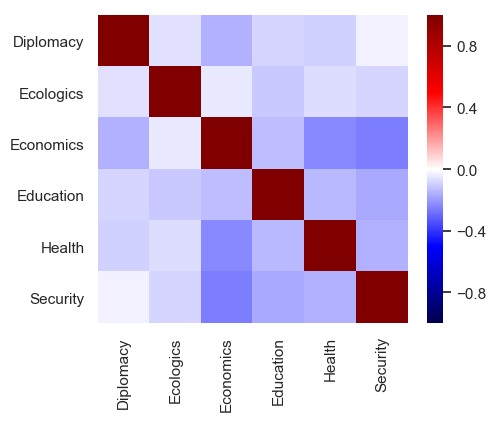

In [17]:
get_correlation_between_topics([17,18,20])

### Conclusions:

We were surprised by the results.
- Security isn't the prime subject (Most of the times) - this might be because some of the security meetings are not recorded because of the data sensitivity. <br/><br/>
- Education is getting much more attention than initially thought.<br/><br/>
- Almost before each start of each year you can see a raise of interest in education. (Probably because of teachers threating to have a strike)<br/><br/>
- Diplomacy score remains pretty much stable throughout the years.<br/><br/>
- We would think the ecology will gain traction throughout the years, but it seems like it is stable at being boring.
- Economic and health are negatively correlated, which means comes one on the expense of the other (capitalism vs. socialism?)<br/><br/>
- Economic and security are also negatively correlated, which might indicates we 'forget' about our financial issues when the matters of national security arise.